# Import Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 

display(cc_apps.head())
cc_apps.info()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.54,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.62,u,g,w,v,1.71,t,f,0,s,0,+


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    int64  
 13  13      690 non-null    object 
dtypes: float64(2), int64(2), object(10)
memory usage: 75.6+ KB


# Data Profiling

In [3]:
profile = ProfileReport(cc_apps, title="Profiling Report")
# profile.to_file("y_profiling_report.html")

# Data Cleaning

In [4]:
# Remove '?' from all rows
cc_apps = cc_apps.map(lambda x: np.nan if x == '?' else x)
cc_apps = cc_apps.dropna()

In [5]:
# Convert numerical values into its type
float_features = [1, 2, 7]
int_features = [10, 12]

for col in cc_apps.columns:
    if col in float_features:
        cc_apps[col] = cc_apps[col].astype('float')
    elif col in int_features:
        cc_apps[col] = cc_apps[col].astype('int')

cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    object 
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    object 
 9   9       659 non-null    object 
 10  10      659 non-null    int32  
 11  11      659 non-null    object 
 12  12      659 non-null    int32  
 13  13      659 non-null    object 
dtypes: float64(3), int32(2), object(9)
memory usage: 72.1+ KB


# EDA

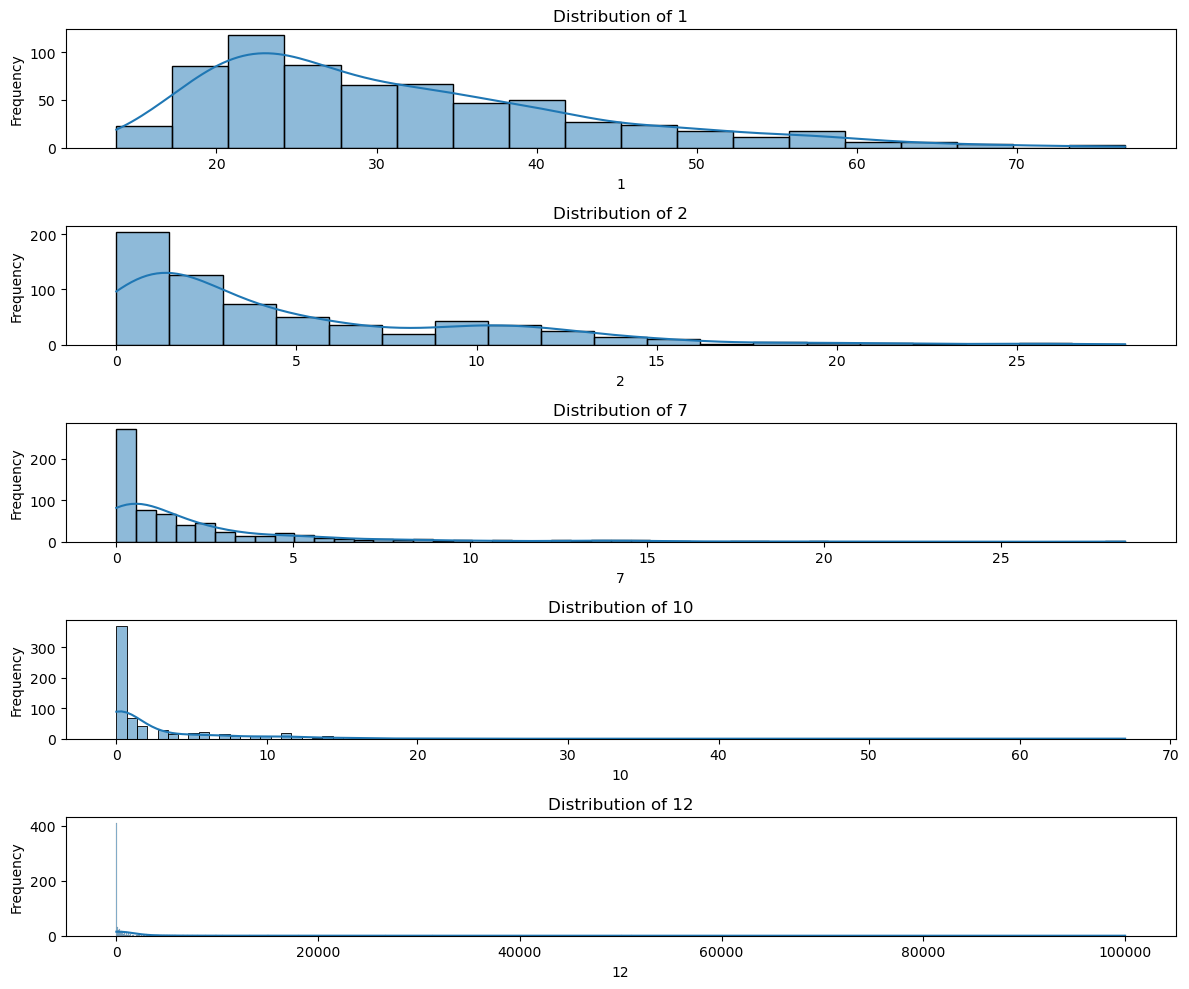

In [6]:
%matplotlib inline

# Check distribution for numerical features
numerical_cols = cc_apps.select_dtypes(include=['number']).columns

# Set up the plot size
plt.figure(figsize=(12, 10))

# Loop through each numerical column and plot its distribution
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)  # create subplots
    sns.histplot(cc_apps[col], kde=True)  # kde=True adds a kernel density estimate line
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

# Preprocessing

## Handling skewed features

In [7]:
# Check the skewness before transformation
print("Before Transformation")
for col in numerical_cols:
    print(f"Column: {col} - Skewwness: {cc_apps[col].skew()}")

# Apply log transformation (ensure no zeros or negative values)
for col in numerical_cols:
    cc_apps[col] = cc_apps[col].apply(lambda x: np.log(x + 1))

# Check the skewness after transformation
print("\nAfter Transformation")
for col in numerical_cols:
    print(f"Column: {col} - Skewwness: {cc_apps[col].skew()}")

Before Transformation
Column: 1 - Skewwness: 1.0835761064547225
Column: 2 - Skewwness: 1.4696290161719654
Column: 7 - Skewwness: 2.895757380832724
Column: 10 - Skewwness: 5.055727376350335
Column: 12 - Skewwness: 12.87332117740245

After Transformation
Column: 1 - Skewwness: 0.3921656523279444
Column: 2 - Skewwness: 0.1683764676379458
Column: 7 - Skewwness: 0.8221095555848732
Column: 10 - Skewwness: 0.9984229266786302
Column: 12 - Skewwness: 0.5009126576404549


## Encoding

In [8]:
# Map all binary and non binary cols
binary_cols = [col for col in cc_apps.columns if cc_apps[col].dtype == 'object' and len(cc_apps[col].value_counts().values) == 2]
multi_cat_cols = [col for col in cc_apps.columns if cc_apps[col].dtype == 'object' and len(cc_apps[col].value_counts().values) > 2]

print(binary_cols)
print(multi_cat_cols)

[0, 8, 9, 13]
[3, 4, 5, 6, 11]


In [9]:
# Convert binary categories to 0/1
cc_apps.loc[:, 0] = cc_apps.loc[:, 0].apply(lambda x: 0 if x == 'a' else 1)
cc_apps.loc[:, 8] = cc_apps.loc[:, 8].apply(lambda x: 0 if x == 'f' else 1)
cc_apps.loc[:, 9] = cc_apps.loc[:, 9].apply(lambda x: 0 if x == 'f' else 1)
cc_apps.loc[:, 13] = cc_apps.loc[:, 13].apply(lambda x: 0 if x == '-' else 1)

# Type casting
for col in binary_cols:
    cc_apps[col] = cc_apps[col].astype('int')

In [10]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 0 to 689
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       659 non-null    int32  
 1   1       659 non-null    float64
 2   2       659 non-null    float64
 3   3       659 non-null    object 
 4   4       659 non-null    object 
 5   5       659 non-null    object 
 6   6       659 non-null    object 
 7   7       659 non-null    float64
 8   8       659 non-null    int32  
 9   9       659 non-null    int32  
 10  10      659 non-null    float64
 11  11      659 non-null    object 
 12  12      659 non-null    float64
 13  13      659 non-null    int32  
dtypes: float64(5), int32(4), object(5)
memory usage: 66.9+ KB


In [11]:
# One-Hot Encode remaining categorical columns
cc_apps = pd.get_dummies(cc_apps, columns=[col for col in multi_cat_cols if col not in binary_cols], drop_first=True)

In [12]:
cc_apps.head()

,0,1,2,7,8,9,10,12,13,3_u,...,6_dd,6_ff,6_h,6_j,6_n,6_o,6_v,6_z,11_p,11_s
0,1,3.46,0.00,0.81,1,1,0.69,0.00,1,True,...,False,False,False,False,False,False,True,False,False,False
1,0,4.09,1.70,1.40,1,1,1.95,6.33,1,True,...,False,False,True,False,False,False,False,False,False,False
2,0,3.24,0.41,0.92,1,0,0.00,6.72,1,True,...,False,False,True,False,False,False,False,False,False,False
3,1,3.36,0.93,1.56,1,1,1.79,1.39,1,True,...,False,False,False,False,False,False,True,False,False,False
4,1,3.05,1.89,1.00,1,0,0.00,0.00,1,True,...,False,False,False,False,False,False,True,False,False,True


In [13]:
# Convert column names to strings
cc_apps.columns = cc_apps.columns.astype(str)

# Modeling

## Split Train & Test

In [14]:
# Prepare Feature Matrix X and Target y
X = cc_apps.drop(columns=['13'])
y = cc_apps['13']

display(X)
display(y)

,0,1,2,7,8,9,10,12,3_u,3_y,...,6_dd,6_ff,6_h,6_j,6_n,6_o,6_v,6_z,11_p,11_s
0,1,3.46,0.00,0.81,1,1,0.69,0.00,True,False,...,False,False,False,False,False,False,True,False,False,False
1,0,4.09,1.70,1.40,1,1,1.95,6.33,True,False,...,False,False,True,False,False,False,False,False,False,False
2,0,3.24,0.41,0.92,1,0,0.00,6.72,True,False,...,False,False,True,False,False,False,False,False,False,False
3,1,3.36,0.93,1.56,1,1,1.79,1.39,True,False,...,False,False,False,False,False,False,True,False,False,False
4,1,3.05,1.89,1.00,1,0,0.00,0.00,True,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,3.09,2.41,0.81,0,0,0.00,0.00,False,True,...,False,False,True,False,False,False,False,False,False,False
686,0,3.16,0.56,1.10,0,1,1.10,5.98,True,False,...,False,False,False,False,False,False,True,False,False,False
687,0,3.27,2.67,1.10,0,1,0.69,0.69,False,True,...,False,True,False,False,False,False,False,False,False,False
688,1,2.94,0.19,0.04,0,0,0.00,6.62,True,False,...,False,False,False,False,False,False,True,False,False,False


0      1
1      1
2      1
3      1
4      1
      ..
685    0
686    0
687    0
688    0
689    0
Name: 13, Length: 659, dtype: int32

In [15]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=9
)

## Modelling with LazyRegressor

In [16]:
clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=accuracy_score)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

 29%|██▉       | 9/31 [00:00<00:00, 30.03it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 97%|█████████▋| 30/31 [00:00<00:00, 29.82it/s]

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 31/31 [00:01<00:00, 29.10it/s]

[LightGBM] [Info] Number of positive: 249, number of negative: 278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 527, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.472486 -> initscore=-0.110168
[LightGBM] [Info] Start training from score -0.110168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,accuracy_score,Time Taken
Model,,,,,,
LinearSVC,0.82,0.84,0.84,0.82,0.82,0.01
LinearDiscriminantAnalysis,0.82,0.84,0.84,0.82,0.82,0.01
RidgeClassifierCV,0.82,0.84,0.84,0.82,0.82,0.01
CalibratedClassifierCV,0.82,0.84,0.84,0.82,0.82,0.02
RidgeClassifier,0.82,0.84,0.84,0.82,0.82,0.01
PassiveAggressiveClassifier,0.82,0.84,0.84,0.82,0.82,0.02
Perceptron,0.80,0.83,0.83,0.81,0.80,0.01
LogisticRegression,0.81,0.82,0.82,0.81,0.81,0.02
LGBMClassifier,0.83,0.82,0.82,0.83,0.83,0.13


## Modelling w (Best Model)

In [17]:
# Create the LGBMClassifier model
best_model = lgb.LGBMClassifier(verbose=-1)

# Perform cross-validation (using 5-fold cross-validation)
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Calculate the mean accuracy score from cross-validation
best_svc_score = cv_scores.mean()

# Print the cross-validation results
print(f"Best LinearSVC Model Accuracy (from cross-validation): {best_svc_score:.4f}")

Best LinearSVC Model Accuracy (from cross-validation): 0.8347


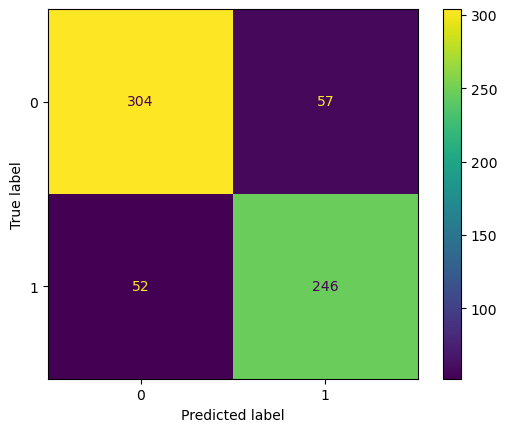

In [18]:
# Use cross_val_predict to get predictions from cross-validation
y_pred_cv = cross_val_predict(best_model, X, y, cv=5)

# Generate the confusion matrix
cm = confusion_matrix(y, y_pred_cv)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.show()

#  Hyperparameter Tuning

In [19]:
# Hyperparameter tuning for LGBMClassifier
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [20, 50, 100],
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(verbose=-1), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit grid search
grid_search.fit(X, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy (from GridSearchCV): {best_score:.4f}")

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}
Best Accuracy (from GridSearchCV): 0.8514
